# This notebook contains the final model used for the web app
* The model uses a Random Forest Classifier

In [48]:
# Modues to be used
import pickle
import json
import csgo
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
# Load the original data
dict_player, df_map, dict_map = csgo.load_data()

In [4]:
df_map.sort_values(['date'],ascending=False).head()

,map_id,map,date,event_id,event_name,team_id_1,team_name_1,team_score_1,team_kills_1,team_deaths_1,team_assists_1,team_rank_1,team_id_2,team_name_2,team_score_2,team_kills_2,team_deaths_2,team_assists_2,team_rank_2,winner
97594,97594,inf,2020-01-10 01:00:00,5164,Aorus League 2019 #4 Northern Cone,10330,Supremacy,16,99.0,93.0,16.0,420,10578,Infamous,12,93.0,100.0,17.0,420,1
97592,97592,nuke,2020-01-10 01:00:00,5164,Aorus League 2019 #4 Northern Cone,10330,Supremacy,16,98.0,69.0,17.0,420,10578,Infamous,8,69.0,98.0,13.0,420,1
97595,97595,inf,2020-01-10 00:35:00,5104,IEM Katowice 2020 North America Closed Qualifier,5752,Cloud9,16,100.0,91.0,14.0,18,9215,MIBR,12,90.0,100.0,16.0,14,1
97593,97593,ovp,2020-01-10 00:35:00,5104,IEM Katowice 2020 North America Closed Qualifier,5752,Cloud9,16,77.0,46.0,11.0,18,9215,MIBR,4,46.0,77.0,10.0,14,1
97591,97591,trn,2020-01-10 00:35:00,5104,IEM Katowice 2020 North America Closed Qualifier,5752,Cloud9,13,90.0,105.0,12.0,18,9215,MIBR,16,105.0,90.0,20.0,14,2


In [12]:
import importlib
importlib.reload(csgo)

N_MAPS      = 50   # Choose -1 for all
MAX_RANK    = 150
DAYS_WEIGHT = 90
START_DATE  = datetime(2016,6,6)

df_all_feat = csgo.create_pre_train_set( dict_player, df_map, dict_map, DAYS_WEIGHT, MAX_RANK, START_DATE, N_MAPS )

## To save the created dataframe, uncomment the folowing lines 
# filename = 'data_models/all_feat_dataframe_DATE.sav'
# pickle.dump( df_ct_start, open(filename,'wb') )

Total number of matches = 29013
Converting data to DataFrame
Total time to create training set = 0:00:06.197061


## We can also load the previously created training set

In [20]:
f = open('data_models/final_train_df.sav','rb')
df_all_feat = pickle.load(f)

In [24]:
print('Total number of matches = ', len(df_all_feat))

Total number of matches =  29013


In [25]:
df_all_feat.head()

,t1_win,fav_win,fav_ind,map,score_dif,t1_rank,t2_rank,t_0_p_0_prize_rating,t_0_p_1_prize_rating,t_0_p_2_prize_rating,...,t_1_p_0_momentum,t_1_p_1_momentum,t_1_p_2_momentum,t_1_p_3_momentum,t_1_p_4_momentum,t_1_p_0_map_rating,t_1_p_1_map_rating,t_1_p_2_map_rating,t_1_p_3_map_rating,t_1_p_4_map_rating
31497,0,1,2,d2,-8,87,40,0.000000,0.000000,0.000000,...,0.400000,0.333333,0.333333,0.333333,0.333333,3.800000,3.636364,2.750000,2.750000,2.750
31498,1,1,1,ovp,3,40,87,0.617108,0.596164,0.596164,...,0.466667,0.466667,0.466667,0.466667,0.333333,NaN,4.000000,4.000000,4.000000,4.000
31504,0,0,1,d2,-10,43,53,0.692579,0.692579,0.692579,...,0.533333,0.533333,0.533333,0.533333,0.333333,-0.250000,-0.700000,-0.875000,-0.875000,-0.875
31505,1,0,2,mrg,2,53,43,0.639377,0.572519,0.569569,...,0.714286,0.714286,0.714286,0.714286,0.714286,12.500000,12.500000,12.500000,12.500000,12.500
31510,0,1,2,cch,-8,136,36,0.495561,0.495561,0.495561,...,0.666667,0.600000,0.466667,0.466667,0.466667,3.533333,3.533333,3.533333,3.533333,1.000


## Now we do some feature engineering

In [32]:
# First we make sure the data is clean
df_all_feat = df_all_feat.fillna(0)

df_train = df_all_feat[['fav_win','t1_win','fav_ind']].copy()

feat_names = ['prize_rating','rating','hs_perc','kills_per_rd','deaths_per_rd','adr',
                'kast','assists_per_rd','flash_per_rd','first_kills_dif','team_rank',
                'score_dif','win_rate','scaled_win','scaled_rating','scaled_score_dif',
                'win_rate_map','kd_per_round','scaled_kd','momentum','map_rating']

# We also create a dictionary for the normalization that will be used for the web app
dict_normalization = {}
for feat in feat_names:

    avg_0 = 0.0*df_all_feat['t_1_p_0_rating']
    avg_1 = 0.0*df_all_feat['t_1_p_1_rating']

    vec_both = []

    for ind in range(0,5):

        avg_0 = avg_0 + df_all_feat['t_0_p_'+str(ind)+'_'+feat]
        avg_1 = avg_1 + df_all_feat['t_1_p_'+str(ind)+'_'+feat]

        vec_both.append( df_all_feat['t_0_p_'+str(ind)+'_'+feat].values ) 
        vec_both.append( df_all_feat['t_1_p_'+str(ind)+'_'+feat].values ) 
   
    # Normalize and save the normalization values for the web app
    dict_normalization[feat] = {}
    dict_normalization[feat]['mean'] = np.mean(vec_both)
    dict_normalization[feat]['std']  = np.std(vec_both)

    avg_0 = (avg_0 - np.mean(vec_both)) / np.std(vec_both)
    avg_1 = (avg_1 - np.mean(vec_both)) / np.std(vec_both)

    df_train[feat+'_dif'] = ( avg_0 - avg_1 ) / 5


df_train['tier_1'] = np.ceil( df_all_feat['t1_rank'] / 20.0 )
df_train['tier_2'] = np.ceil( df_all_feat['t2_rank'] / 20.0 )

df_train = df_train.fillna(0)

df_train['fav_ind']   = -1.0*(df_train['prize_rating_dif']>=0.0) + 1.0*(df_train['prize_rating_dif']<0.0)
df_train['fav_ind_2'] = -1.0*(df_train['rating_dif']>=0.0) + 1.0*(df_train['rating_dif']<0.0)
df_train['fav_ind_3'] = -1.0*(df_train['kills_per_rd_dif']>=0.0) + 1.0*(df_train['kills_per_rd_dif']<0.0)

print('Mean of CT wins = ',df_train['t1_win'].mean())

df_train.tail(n=80)

Mean of CT wins =  0.5008789163478441


,fav_win,t1_win,fav_ind,prize_rating_dif,rating_dif,hs_perc_dif,kills_per_rd_dif,deaths_per_rd_dif,adr_dif,kast_dif,...,scaled_score_dif_dif,win_rate_map_dif,kd_per_round_dif,scaled_kd_dif,momentum_dif,map_rating_dif,tier_1,tier_2,fav_ind_2,fav_ind_3
97490,0,0,-1.0,0.703403,-0.348008,-0.425264,-0.416823,0.214299,-0.376182,-0.254745,...,-1.124069,-0.126876,-0.541530,-0.874358,-1.353951,-1.084605,2.0,4.0,1.0,1.0
97491,1,0,-1.0,1.343076,2.005799,0.646436,1.535165,1.321096,1.654750,2.972975,...,0.053010,-0.002953,0.504626,0.025537,2.080160,-0.470765,6.0,5.0,-1.0,-1.0
97492,0,0,1.0,-0.255373,0.010410,-0.169967,0.017783,-0.082043,-0.083886,0.005859,...,-0.770420,0.006047,0.074568,-0.689170,-1.846296,-0.973705,2.0,2.0,-1.0,-1.0
97493,1,0,1.0,-0.703403,0.348008,0.425264,0.416823,-0.214299,0.376182,0.254745,...,1.124069,-0.379142,0.541530,0.874358,1.353951,-1.892290,4.0,2.0,-1.0,-1.0
97494,0,1,-1.0,0.255373,-0.010410,0.169967,-0.017783,0.082043,0.083886,-0.005859,...,0.770420,0.101901,-0.074568,0.689170,1.846296,0.354458,2.0,2.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97582,1,0,1.0,-0.167106,-0.119458,0.013971,-0.007506,0.153676,0.025360,-0.244807,...,0.067229,-3.729163,-0.115517,-0.471349,-1.040080,-0.585793,2.0,1.0,1.0,1.0
97586,1,0,1.0,-0.167106,-0.119458,0.013971,-0.007506,0.153676,0.025360,-0.244807,...,0.067229,-0.723486,-0.115517,-0.471349,-1.040080,0.332305,2.0,1.0,1.0,1.0
97591,1,0,1.0,-0.534889,0.288002,0.219408,0.146491,0.113026,0.237025,0.285987,...,-0.920322,-0.089541,0.057358,-0.920074,-1.120086,0.692301,1.0,1.0,-1.0,-1.0
97593,0,0,-1.0,0.534889,-0.288002,-0.219408,-0.146491,-0.113026,-0.237025,-0.285987,...,0.920322,0.014856,-0.057358,0.920074,1.120086,-0.847025,1.0,1.0,1.0,1.0


### In case we want to save the normalization dictionary

In [ ]:
# # Save the normaliation dictionary for the web app
# filename = 'dict_normalization_DATE.sav'
# pickle.dump( dict_normalization, open(filename,'wb') )

## Now let's look at some descriptive metrics of the data set

In [33]:
df_train.head()

,fav_win,t1_win,fav_ind,prize_rating_dif,rating_dif,hs_perc_dif,kills_per_rd_dif,deaths_per_rd_dif,adr_dif,kast_dif,...,scaled_score_dif_dif,win_rate_map_dif,kd_per_round_dif,scaled_kd_dif,momentum_dif,map_rating_dif,tier_1,tier_2,fav_ind_2,fav_ind_3
31497,1,0,1.0,-2.744813,-0.287202,-0.482375,-0.132118,0.661124,-0.086233,0.082032,...,-0.004961,-0.309352,-0.590422,0.047588,0.560043,2.675808,5.0,2.0,1.0,1.0
31498,1,1,-1.0,2.744813,0.287202,0.482375,0.132118,-0.661124,0.086233,-0.082032,...,0.004961,0.067884,0.590422,-0.047588,-0.560043,-0.609225,2.0,5.0,-1.0,-1.0
31504,0,0,-1.0,1.233932,0.507523,0.055802,0.363711,-0.515563,0.328587,0.142579,...,-0.003264,0.016942,0.704487,-0.096250,1.325817,2.413363,3.0,3.0,-1.0,-1.0
31505,0,1,1.0,-1.233932,-0.507523,-0.055802,-0.363711,0.515563,-0.328587,-0.142579,...,0.003264,-0.156677,-0.704487,0.096250,-1.325817,-2.492285,3.0,3.0,1.0,1.0
31510,1,0,1.0,-1.117700,-0.709331,0.072305,-0.390634,1.461417,0.077261,-0.489566,...,-0.355315,-0.267682,-1.397430,-0.372656,-1.360105,-1.511986,7.0,2.0,1.0,1.0


In [34]:
df_train[['fav_win', 't1_win', 'fav_ind', 'map_rating_dif']].head(n=10)

,fav_win,t1_win,fav_ind,map_rating_dif
31497,1,0,1.0,2.675808
31498,1,1,-1.0,-0.609225
31504,0,0,-1.0,2.413363
31505,0,1,1.0,-2.492285
31510,1,0,1.0,-1.511986
31511,1,1,-1.0,0.542764
31524,1,0,1.0,-0.626941
31528,1,0,1.0,-0.074235
31529,0,0,1.0,0.166152
31530,1,0,1.0,-1.276999


In [44]:
df_train.describe()

,fav_win,t1_win,fav_ind,prize_rating_dif,rating_dif,hs_perc_dif,kills_per_rd_dif,deaths_per_rd_dif,adr_dif,kast_dif,...,scaled_score_dif_dif,win_rate_map_dif,kd_per_round_dif,scaled_kd_dif,momentum_dif,map_rating_dif,tier_1,tier_2,fav_ind_2,fav_ind_3
count,29013.000000,29013.000000,29013.000000,29013.000000,29013.000000,29013.000000,29013.000000,29013.000000,29013.000000,29013.000000,...,29013.000000,29013.000000,29013.000000,29013.000000,29013.000000,29013.000000,29013.000000,29013.000000,29013.000000,29013.000000
mean,0.607452,0.500879,-0.012029,0.012314,0.013460,-0.002862,0.009974,-0.007909,0.009712,0.012838,...,0.011716,-0.028001,0.014921,0.010761,0.002976,-0.102117,2.955916,2.986523,-0.012098,-0.011753
std,0.488326,0.500008,0.999945,0.889136,0.769483,0.518543,0.630627,0.760666,0.612973,0.791830,...,1.279341,1.174288,0.810786,0.937209,1.174507,1.281473,1.819160,1.858701,0.999944,0.999948
min,0.000000,0.000000,-1.000000,-4.577593,-5.910356,-3.382910,-5.960833,-8.465565,-6.526893,-8.496918,...,-15.615358,-23.178578,-5.212296,-8.676804,-4.935765,-7.476855,1.000000,1.000000,-1.000000,-1.000000
25%,0.000000,0.000000,-1.000000,-0.457738,-0.410786,-0.331978,-0.302026,-0.418975,-0.262815,-0.340026,...,-0.281188,-0.204069,-0.498176,-0.208306,-0.800062,-0.889909,1.000000,1.000000,-1.000000,-1.000000
50%,1.000000,1.000000,-1.000000,0.008565,0.010266,-0.003306,0.005993,-0.014601,0.005176,0.006958,...,0.000404,-0.011289,0.016553,0.002296,0.000000,-0.092307,3.000000,3.000000,-1.000000,-1.000000
75%,1.000000,1.000000,1.000000,0.469107,0.433554,0.325947,0.317264,0.404025,0.273618,0.355418,...,0.283309,0.166314,0.526476,0.214379,0.800062,0.684999,4.000000,4.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,4.362335,5.349599,3.113949,5.071205,5.543184,5.516330,7.061607,...,15.758103,23.706124,4.661788,8.676804,4.935765,6.369173,8.000000,8.000000,1.000000,1.000000


### Let's look at the distribution of all the features

/home/emmanuel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  del sys.path[0]


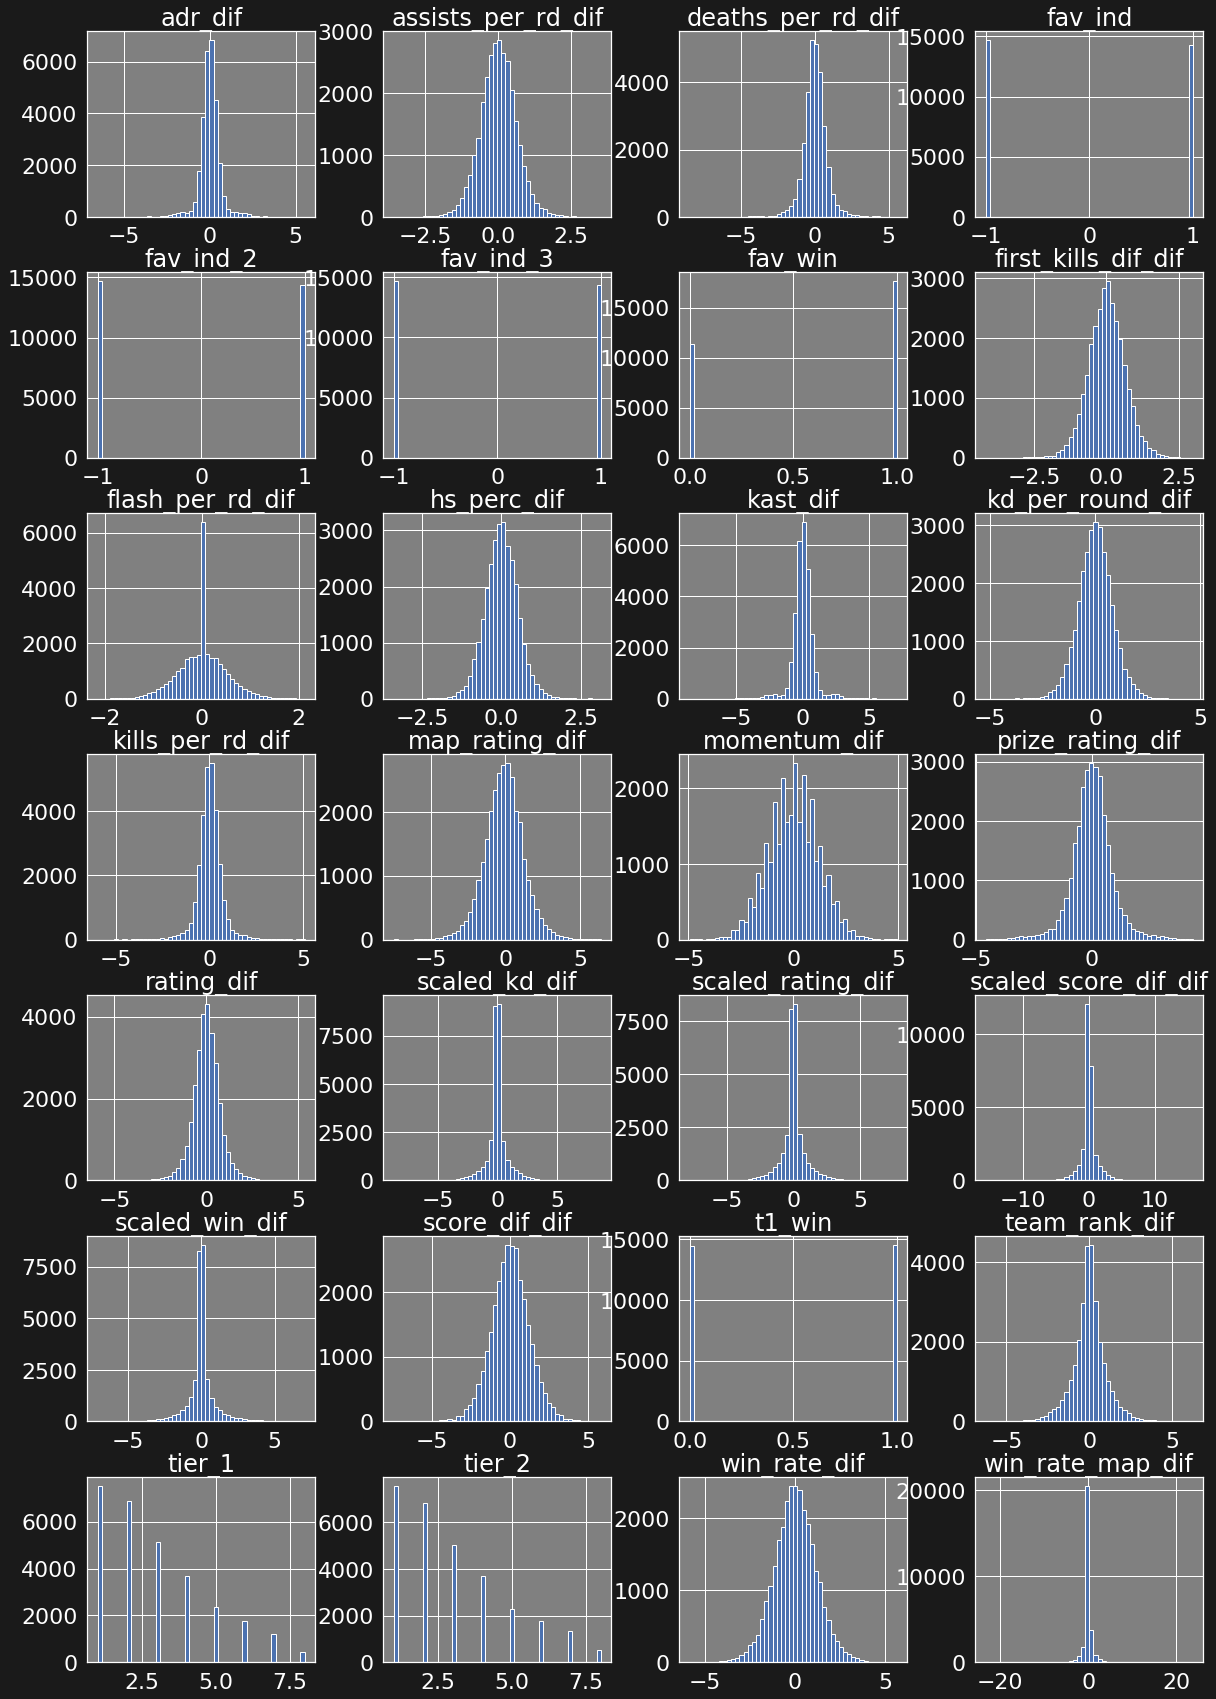

In [108]:
sns.set_style("whitegrid")
sns.set(font_scale=2)

fig = plt.figure(figsize=(20,30))
mpl.rcParams.update({'text.color' : "white",
                     'axes.labelcolor' : "white",
                     'xtick.color' : "white",
                     'ytick.color' : "white",
                     'axes.facecolor':"gray"})

ax = plt.axes()

df_train.hist(ax=ax,bins=50,layout=(7,4))

fig.set_facecolor('k')

In [45]:
df_train[df_train['t1_win']==1][['prize_rating_dif','scaled_win_dif']].describe()

,prize_rating_dif,scaled_win_dif
count,14532.000000,14532.000000
mean,0.229823,0.178527
std,0.867470,0.998451
min,-4.362335,-7.048971
25%,-0.259415,-0.094753
50%,0.193182,0.061268
75%,0.652803,0.331620
max,4.362335,7.048971


In [46]:
df_train[df_train['t1_win']==0][['prize_rating_dif','scaled_win_dif']].describe()

,prize_rating_dif,scaled_win_dif
count,14481.000000,14481.000000
mean,-0.205962,-0.158692
std,0.856553,0.953556
min,-4.577593,-7.006181
25%,-0.636832,-0.325181
50%,-0.174818,-0.057677
75%,0.275975,0.102596
max,4.052510,7.048971


## Let's look at the correlation matrix to see what we can get rid of

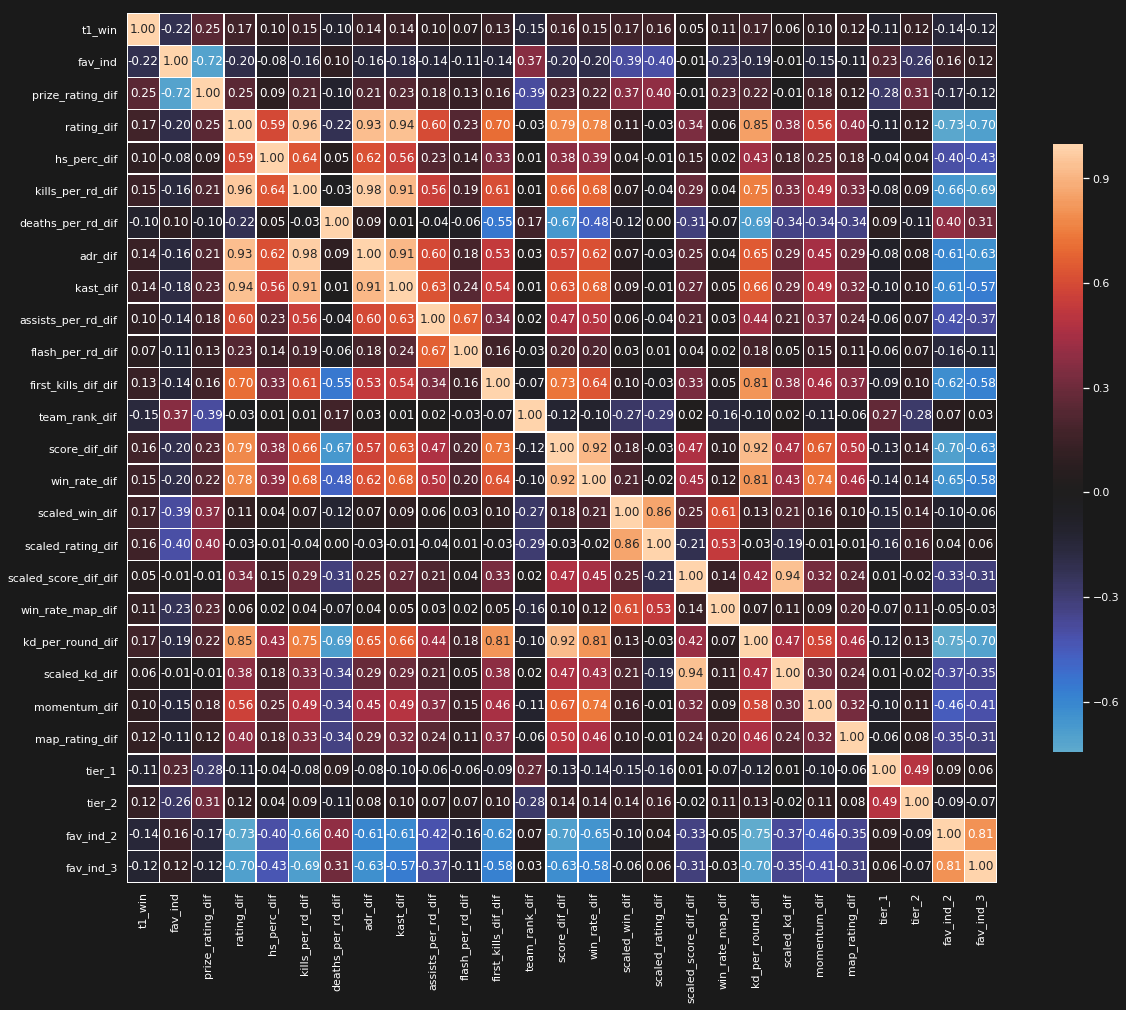

In [106]:
correlations = df_train.drop(['fav_win'],axis=1).corr()

sns.set_style("whitegrid")
sns.set(font_scale=1)

fig = plt.figure(figsize=(20,16));

mpl.rcParams.update({'text.color' : "white",
                     'axes.labelcolor' : "white",
                     'xtick.color' : "white",
                     'ytick.color' : "white",
                     'axes.facecolor':"gray"})

ax = plt.axes()

sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}, ax=ax);

fig.set_facecolor('k')

In [53]:
print('Fraction of matches on which the one with the highest prize rating wins:')
print(df_train['fav_win'].mean())

Fraction of matches on which the one with the highest prize rating wins:
0.6074518319374074


In [54]:
df_train.keys().values

array(['fav_win', 't1_win', 'fav_ind', 'prize_rating_dif', 'rating_dif',
       'hs_perc_dif', 'kills_per_rd_dif', 'deaths_per_rd_dif', 'adr_dif',
       'kast_dif', 'assists_per_rd_dif', 'flash_per_rd_dif',
       'first_kills_dif_dif', 'team_rank_dif', 'score_dif_dif',
       'win_rate_dif', 'scaled_win_dif', 'scaled_rating_dif',
       'scaled_score_dif_dif', 'win_rate_map_dif', 'kd_per_round_dif',
       'scaled_kd_dif', 'momentum_dif', 'map_rating_dif', 'tier_1',
       'tier_2', 'fav_ind_2', 'fav_ind_3'], dtype=object)

# Import the required packages for the models

In [74]:
import xgboost as xgb
import matplotlib as mpl

from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

--------------------------------------------------------------
Random Forest

Accuracy (Train): 0.6862
AUC Score (Train): 0.755152

>              precision    recall  f1-score   support

     T Start       0.63      0.62      0.63      3519
    CT Start       0.62      0.63      0.63      3477

   micro avg       0.63      0.63      0.63      6996
   macro avg       0.63      0.63      0.63      6996
weighted avg       0.63      0.63      0.63      6996

Accuracy (Test): 0.6269
AUC Score (Test): 0.626949
--------------------------------------------------------------
Random Forest

Accuracy (Train): 0.6858
AUC Score (Train): 0.755108

>              precision    recall  f1-score   support

     T Start       0.62      0.63      0.63      3501
    CT Start       0.63      0.62      0.62      3495

   micro avg       0.62      0.62      0.62      6996
   macro avg       0.62      0.62      0.62      6996
weighted avg       0.62      0.62      0.62      6996

Accuracy (Test): 0.6249
AUC S

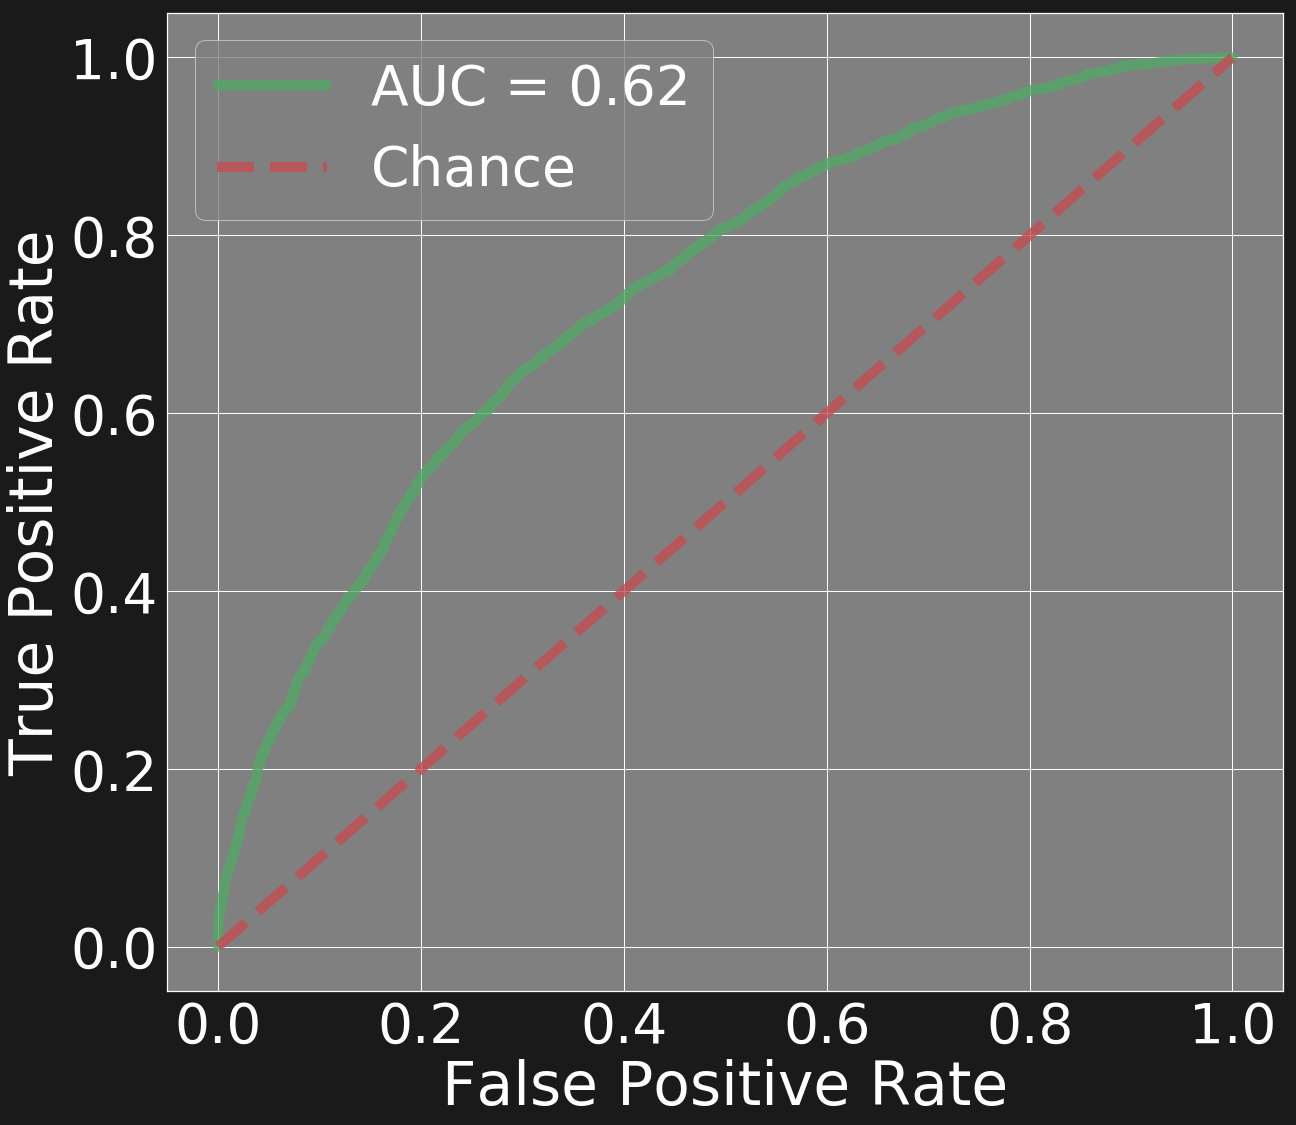

In [91]:
# Choose a model
# -> 'rf'  = Random Forest
# -> 'xgb' = XGBoost
# -> 'log' = Logistic
model_case = 'rf' 

# These features are giving 63%
features = ['t1_win', 'prize_rating_dif',  'score_dif_dif', 
        'win_rate_dif', 'scaled_win_dif', 'scaled_rating_dif','win_rate_map_dif', 'kd_per_round_dif',
        'momentum_dif']

labels = ['Team 1 win', '$\Delta$ Prize Rating', '$\Delta$ Score', '$\Delta$ Win %', '$\Delta$ Scaled Win',
        '$\Delta$ Scaled Rating', '$\Delta$ Win % Map', '$\Delta$ KD per Round', '$\Delta$ Momentum']

# Make a copy for the training
df_tmp = df_train[ features ].copy()

# Get rid of outliers
df_tmp = df_tmp[ np.abs(df_tmp['scaled_rating_dif'])<3.0 ]
df_tmp = df_tmp[ np.abs(df_tmp['kd_per_round_dif'])<3.0 ]
df_tmp = df_tmp[ np.abs(df_tmp['scaled_win_dif'])<3.0 ]

# Get arrays for the training/testing
n = len(df_tmp.keys())
X = df_tmp.iloc[:, 1:n].values
y = df_tmp.iloc[:, 0].values

# Create splits for the cross-validation
cv = KFold(n_splits=4, random_state=None, shuffle=True)


# Choose the model 
if model_case == 'xgb':

    model = XGBClassifier(
        learning_rate=0.01,
        n_estimators=500,
        max_depth=8,
        min_child_weight=1,
        gamma=10,
        subsample=0.8,
        colsample_bytree=0.6,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1 )

    title_string = 'XGBoost'

elif model_case == 'rf':
    
    model = RandomForestClassifier(
            n_estimators=200,
            max_depth=8, 
            random_state=1, 
            bootstrap=False, 
            n_jobs=6)

    title_string = 'Random Forest'

elif model_case == 'log':

    model = LogisticRegression(max_iter=500)

    title_string = 'Logistic Regression'


# Loop for the cross-validation
accuracy_vec = []

for train_index, test_index in cv.split(X):

    X_train, X_test, y_train, y_test = X[train_index,:], X[test_index,:], y[train_index], y[test_index]
    
    model.fit(X_train, y_train)
    y_pred        = model.predict(X_test)
    y_train_pred  = model.predict(X_train)
    y_train_proba = model.predict_proba(X_train)[:,1]

    predictions = [round(value) for value in y_pred]    

    print('--------------------------------------------------------------')
    print(title_string)
    print('')
    print('Accuracy (Train): %.4g' % accuracy_score(y_train, y_train_pred) )
    print('AUC Score (Train): %f' % roc_auc_score(y_train, y_train_proba) )
    print('')
    print('>'+classification_report(y_test,predictions,target_names=['T Start','CT Start']))

    print('Accuracy (Test): %.4g' % accuracy_score(y_test, y_pred) )
    print('AUC Score (Test): %f' % roc_auc_score(y_test, y_pred) )

    accuracy_vec.append( accuracy_score(y_test, y_pred) )

print(' ')
print(' ')
print('--------------------------------------------------------------')
print('Avg accuracy (Test)  = %f' % np.mean(accuracy_vec) )
print('Standard dev. (Test) = %f' % np.std(accuracy_vec) )
print('--------------------------------------------------------------')
print(' ')
print(' ')

sns.set_style("whitegrid")
sns.set(font_scale=5)

fig = plt.figure(figsize=(20,18));

mpl.rcParams.update({'text.color' : "white",
                     'axes.labelcolor' : "white",
                     'xtick.color' : "white",
                     'ytick.color' : "white",
                     'axes.facecolor':"gray"})

ax = plt.axes()

fpr, tpr, thresholds = metrics.roc_curve(y_test, clf.predict_proba(X_test)[:,1] )  # doctest: +SKIP

ax.plot( fpr, tpr, lw=10, color='g',
        label='AUC = %.2f' % (roc_auc_score(y_test, y_pred)), alpha=.8 )

ax.plot([0, 1], [0, 1], linestyle='--', lw=10, color='r',
        label='Chance', alpha=.8 )

fig.set_facecolor('k')

plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# plt.savefig('ROC_feb9.png', transparent=True, bbox_inches="tight")
plt.show()

### To save the Random Model

In [905]:
# filename = 'final_model_rand_forest_DATE.sav'
# pickle.dump( clf, open(filename,'wb') )

## Let's look at the feature importance

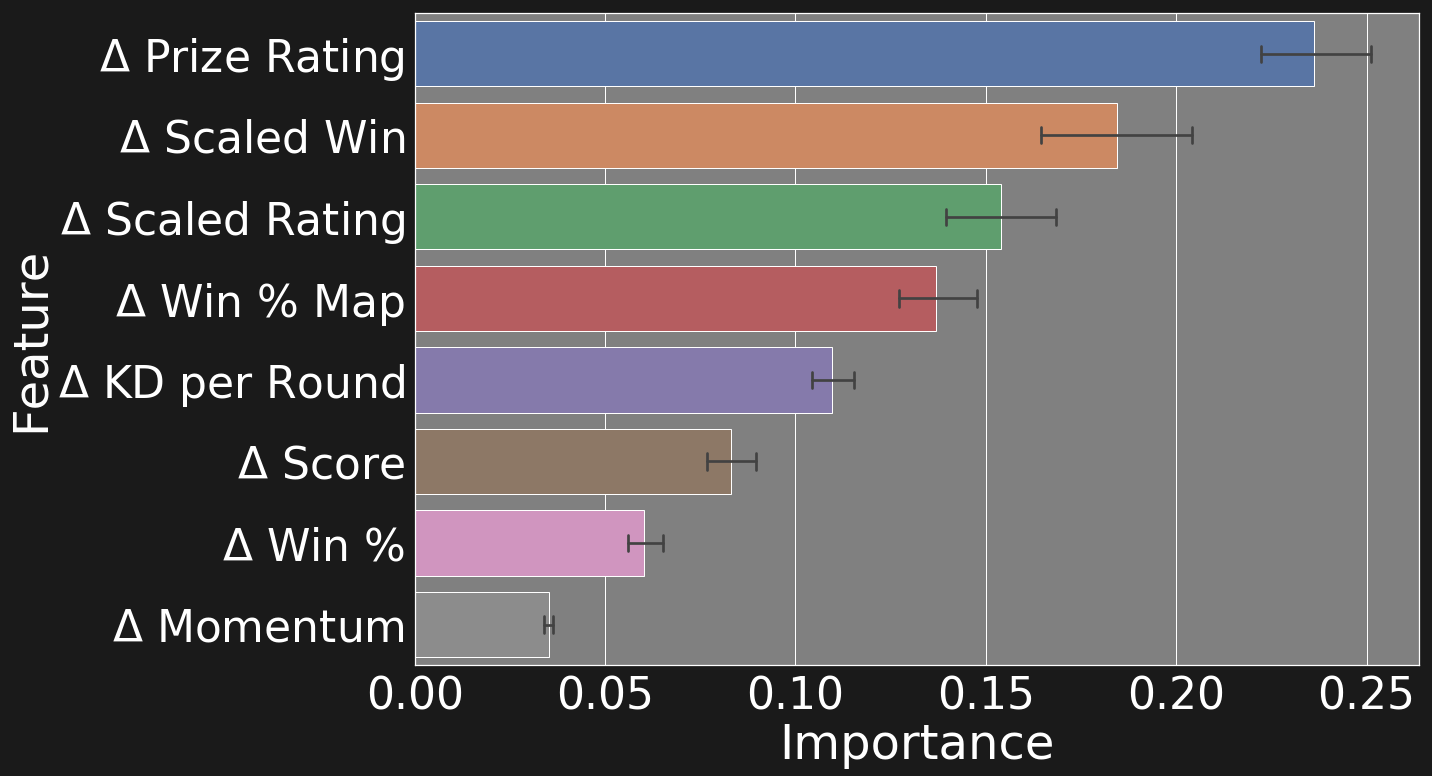

In [73]:
order = np.argsort( clf.feature_importances_ )[::-1][:n]
feat_new = [labels[order[ind]+1] for ind in range(0,n-1)]

dic_aux = {}
dic_aux['Feature'] = []
dic_aux['Importance'] = []
count = -1
for tree in clf.estimators_:
    count = count+1
    
    for ind in range(0,n-1):
        dic_aux['Feature'].append( labels[ind+1] )
        dic_aux['Importance'].append( tree.feature_importances_[ind] )

df = pd.DataFrame.from_dict(dic_aux,orient="columns")

sns.set_style("whitegrid")
sns.set(font_scale=4)

fig = plt.figure(figsize=(12*1.5,8*1.5));

mpl.rcParams.update({'text.color' : "white",
                     'axes.labelcolor' : "white",
                     'xtick.color' : "white",
                     'ytick.color' : "white",
                     'axes.facecolor':"gray"})

ax = plt.axes()
ax = sns.barplot(x="Importance", y="Feature", data=df, order=feat_new, capsize=0.2 )

fig.set_facecolor('k')

# plt.savefig('importance_feb9.png', transparent=True, bbox_inches="tight")


## Distribution of the final features

/home/emmanuel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


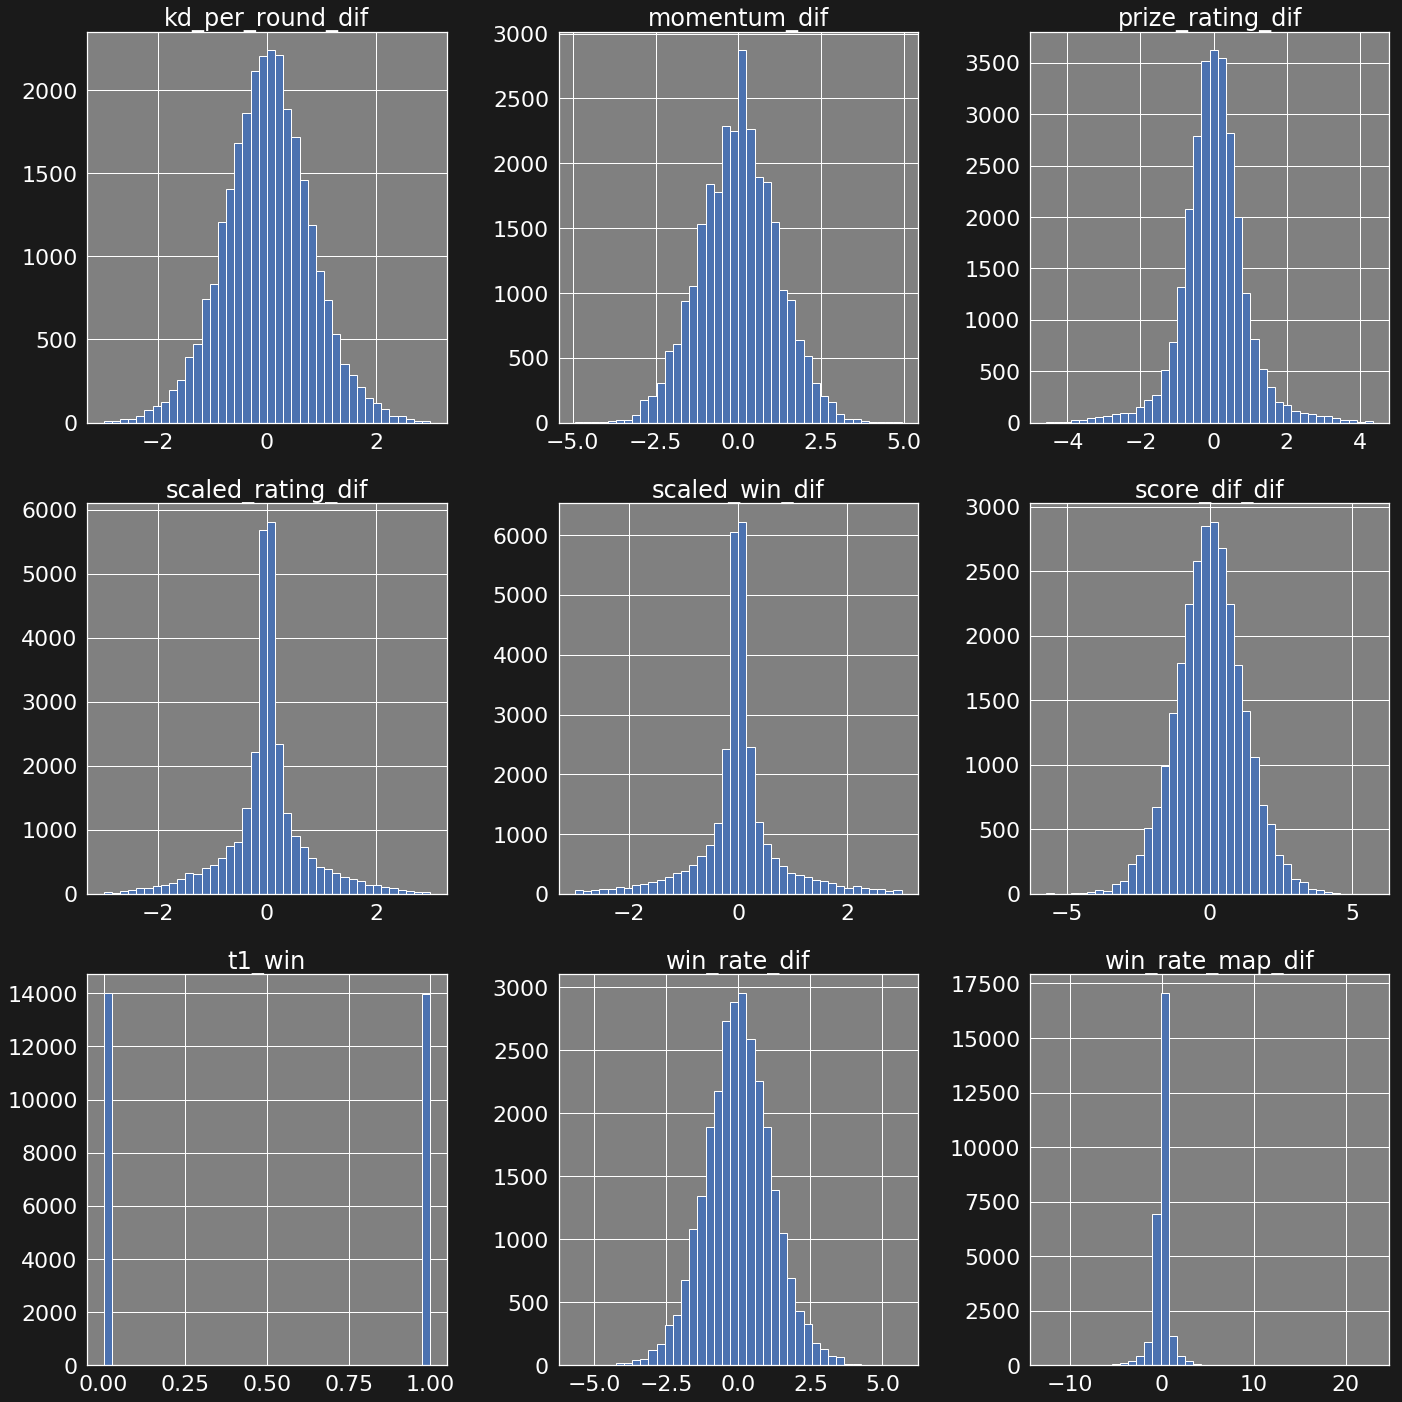

In [102]:

sns.set_style("whitegrid")
sns.set(font_scale=2)

fig = plt.figure(figsize=(20,20))

mpl.rcParams.update({'text.color' : "white",
                     'axes.labelcolor' : "white",
                     'xtick.color' : "white",
                     'ytick.color' : "white",
                     'axes.facecolor':"gray"})

ax = plt.axes()
df_tmp.hist(ax=ax,bins=40,layout=(3,3))
plt.tight_layout()
fig.set_facecolor('k')
plt.show()


## Correlation of the final features

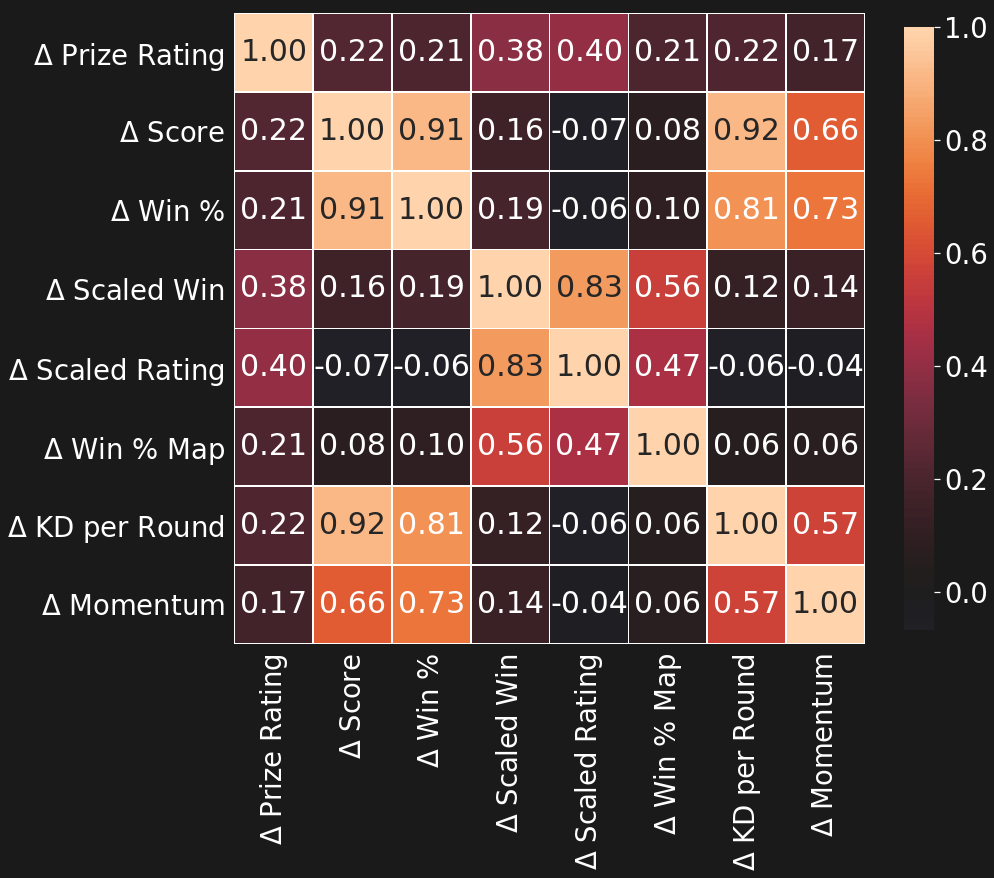

In [105]:
correlations = df_tmp.drop(['t1_win'],axis=1).corr()


sns.set_style("whitegrid")
sns.set(font_scale=2.5)

fig = plt.figure(figsize=(15,15));

mpl.rcParams.update({'text.color' : "white",
                     'axes.labelcolor' : "white",
                     'xtick.color' : "white",
                     'ytick.color' : "white",
                     'axes.facecolor':"gray"})
ax = plt.axes()

sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}, ax=ax,
                xticklabels=labels[1:n],
                yticklabels=labels[1:n])

plt.tight_layout()
fig.set_facecolor('k')
plt.show()

# plt.savefig('correlations_feb9.png', transparent=True, bbox_inches="tight")